# Makemore: Bigram Part 4

### In this notebook, we will develop a bigram character language model using a neural network approach. The neural network will take a single character as input, process it through the network with weights/parameters ```w```, and output the character most likely to follow the input character in the sequence.

- Additionally, we will evaluate different parameter settings of the neural network using the loss function, specifically the ```negative log likelihood.``` By examining the ```probability distributions``` and using labels (which represent the next character in the bigram), we can determine how accurately the model predicts the following character. Our goal is to achieve a high probability for the correct next character, resulting in a low loss.

- We will employ ```gradient-based optimization``` to fine-tune the network. By minimizing the loss function, we will adjust the network's weights/parameters to accurately predict the probabilities of the subsequent character in the sequence.

### Start by running the following:

In [2]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#load names.text for reading into a massive string. Then move it into a python list of strings
words = open('names.txt', 'r').read().splitlines()

In [4]:
chars = sorted(list(set(''.join(words)))) #make words one big string of chars, and then into a list of sorted, unique chars
stoi = {s : i+1 for i,s in enumerate(chars)} #string to integer map, shift values for '.'
stoi['.'] = 0
itos = {i : s for s, i in stoi.items()}

### We're going to start by compiling a training set of the bigram for the neural network.

The training set will be made up of two lists: the inputs, and the targets.

In [10]:
xs, ys = [], [] #inputs and targets

for w in words[:1]:
    chs x= ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        print(ch1, ch2)
        xs.append(ix1)
        ys.append(ix2)

#create tensors out of this
xs = torch.tensor((xs)) #not torch.Tensor(which would cast as float) 
ys = torch.tensor((ys))

. e
e m
m m
m a
a .


In [8]:
xs

tensor([ 0,  5, 13, 13,  1])

In [9]:
ys

tensor([ 5, 13, 13,  1,  0])

### How do we read this?

- There are 5 bigrams in the input word ```emma```.
- When the input integer is $0$ in ```xs```, which maps to input ```'.'``` in ```stoi```, the desired ```label``` is integer $5$ in ```ys```, which corresponds to ```e```.
- Thus, when the input to the neural network is integer $5$, we want to adjust the parameters so integer $13$ gets a very high probability, and so on.
  

### Feeding Integers into Neural Networks: One-Hot Encoding

- Right now, we're plugging in an integer input that represents the index of the character, which you can't really input to a neural network. It doesn't really make sense to feed in an input of integers to the neuron to be multiplied by the weights. So we should use a different way of encoding the integers.
- In ```one-hot encoding```, instead of passing the integer $13$, we would pass in a vector with the $13th$ index filled with a $1$, and the rest of the indexes filled with $0's$.
- ```PyTorch``` has a ```one-hot encoding``` function that takes a tensor made of integers, and ```num_classes```, which is how long you want your tensor to be. 


In [11]:
import torch.nn.functional as F

In [19]:
xencoded = F.one_hot(xs, num_classes=27).float() #ca sted to float because doesn't take dtype input
xencoded #xs has 5 examples, set to length 27 each. 5 examples coded into tensors

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [20]:
print(xencoded.dtype) #automatically an integer becasue we passed xs which are 64 bit integers, but now a float
xencoded.shape

torch.float32


torch.Size([5, 27])

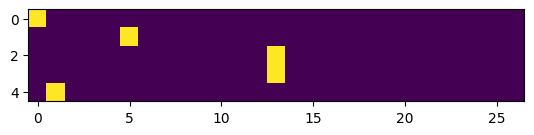

In [21]:
plt.imshow(xencoded)

### Let's make our first neuron. The neurons will perform a simple function ```w(x) + b```, where ```w(x)``` is a dot product.

Let's initialize the weights for the neuron.

In [23]:
W = torch.randn((27,1)) #column vector, where 1 indicates the presence of 1 single neuron

#Now, weights are multiplied by the inputs
#take the one-hot encoding and multiply it by w, with matrix mult. or greater in pytorch

xencoded @ W

tensor([[2.1636],
        [0.6641],
        [1.5792],
        [1.5792],
        [1.0138]])

The operation ```xencoded @ W ```performs matrix multiplication to evaluate the dot product for each input example with all neurons. This is done in parallel, allowing efficient computation of probabilities for the next character in the sequence.

### Basically, we took ```x-encoding```, which is $5x27$, and we multiplied it by $27x1$. The output will become $5x1$, because the $27$ will multiply and add.

- We're seeing the $5$ activations of the ```W``` nueron on the $5$ inputs from ```xencoded```. We inputed all $5$ inputs to the same neuron and evaluated them (using ```w(x) + b``` in parallel.  

### Now, we want to create $27$ neurons, so we can evaluate all 27 neurons on all 5 inputs in parallel:

In [27]:
W = torch.randn((27,27)) #27 neurons
print(xencoded @ W) #now multiplying 5x27 * 27*27 neuron, which output 5x27
(xencoded @ W).shape

tensor([[ 1.4820, -1.1094, -0.8787,  0.5043,  0.3617,  1.2164,  0.5823, -1.7402,
         -1.4040, -1.5237,  0.9622,  1.0588, -0.6319, -1.4658, -1.2474,  0.5097,
          1.1323,  0.9731, -0.3893, -0.2970, -0.6915, -0.5404,  1.3155,  1.6806,
         -1.8419, -0.4272, -0.1364],
        [-1.4081,  0.9108, -0.9205, -0.3495,  0.3606,  0.2921, -0.8392, -0.9323,
         -1.6665,  1.1338,  0.3525,  0.0339,  0.2599, -0.5840, -0.5575, -0.1619,
         -0.8952,  1.8736, -1.6432, -1.2224, -0.5003, -0.9029,  1.4006,  2.0920,
          1.9899,  0.8264, -0.7327],
        [-0.8857, -0.5182, -0.8138, -0.8223,  0.2427, -0.6459, -1.4622,  2.3162,
         -0.5067,  0.1217,  1.6059,  0.1532,  1.1719,  0.1739,  0.8752, -0.1940,
         -0.4199,  0.3347,  1.1409,  0.4607,  0.5146, -0.8147,  0.0952,  0.0900,
          1.1077, -1.0880, -0.1864],
        [-0.8857, -0.5182, -0.8138, -0.8223,  0.2427, -0.6459, -1.4622,  2.3162,
         -0.5067,  0.1217,  1.6059,  0.1532,  1.1719,  0.1739,  0.8752, -0.1940

torch.Size([5, 27])

### This operation is essentially telling us, "for the 27 neurons we made, what is the firing rate of those neurons on every one of the $5$ of those examples?

In [35]:
(xencoded @ W)[3,13] #retrieves value from matrix product; the firing rate of the 13th neuron, looking at the 3rd input
                    #achieved using the product of the 3rd input and the 13th column of the W matrix (activation of 13th neuron for the 3rd input)

tensor(0.1739)

### Using matrix multiplication, we can very efficiently evaluate the dot product using lots of input examples in the batch, and lots of neurons, where all of those neurons have weights in the columns of those W's. We're doing those dot products in parallel.

To explore this, we can take the $3rd$ row of ```xencoded``` and the $13th$ column of W, and can element-wise multiply them, and then sum them up. Finally, we check this against the original result of:
```python
(xencoded @ W)[3,13]
```

In [29]:
(xencoded[3])

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [30]:
W[:,13]

tensor([-1.4658, -2.0683, -1.4208,  1.7738, -0.2589, -0.5840, -0.3703, -0.8808,
         1.0854,  0.3849,  1.1077, -0.8994, -0.5985,  0.1739, -0.7326, -1.5873,
         2.1938, -0.8535, -0.4942, -0.8401, -1.1109, -0.7709, -0.5695,  0.6647,
         0.3222,  0.0155, -0.2095])

In [34]:
(xencoded[3] * W[:,13]).sum() #w(x) + b without the b 

tensor(0.1739)

### Our answer is the same as ```(xencoded @ W)[3,13]``` because each element at the resulting matrix at position ```[i,j]``` is the ```dot-product``` of the ```ith``` row of matrix ```xencoded``` and the ```jth``` column of matrix ```W```.

Now, we have a $27$ dimensional input and a first-layer (a linear) of $27$ neurons. These neurons don't have a ```bias```, and don't have a ```non-linearity``` like ```tanh()```. It's just a linear layer.

### For every single input example, we're trying to produce a probability distribution for the next character in a sequence ($27$ of them). But how are we going to interpret the $27$ numbers these neurons take on?

In our previous bigram model, we had a matrix of normalized probabilites derived from the counts of the character sequences. Right now, all we have are some negative and positive numbers, which we want to represent the probabilities for the next character.

Since it's difficult to output counts (integers), and probabilities (positive numbers that add up to 1) out of a neural network, we can interpet the $27$ numbers as ```log(counts)```, where we take the counts and exponentiate them. 

As a result, the numbers in the output tensor that were below $0$ will be below $1$, but still positive, and those above $0$ will turn into even more positive numebrs, i/e higher than $1$.  

In [36]:
(xencoded @ W).exp() # e^x 

tensor([[ 4.4019,  0.3298,  0.4153,  1.6558,  1.4358,  3.3752,  1.7902,  0.1755,
          0.2456,  0.2179,  2.6175,  2.8828,  0.5316,  0.2309,  0.2873,  1.6649,
          3.1029,  2.6462,  0.6776,  0.7430,  0.5008,  0.5825,  3.7265,  5.3687,
          0.1585,  0.6523,  0.8725],
        [ 0.2446,  2.4863,  0.3983,  0.7050,  1.4342,  1.3393,  0.4320,  0.3937,
          0.1889,  3.1074,  1.4226,  1.0345,  1.2968,  0.5577,  0.5726,  0.8506,
          0.4085,  6.5117,  0.1934,  0.2945,  0.6064,  0.4054,  4.0578,  8.1012,
          7.3149,  2.2851,  0.4806],
        [ 0.4124,  0.5956,  0.4432,  0.4394,  1.2747,  0.5242,  0.2317, 10.1374,
          0.6025,  1.1294,  4.9822,  1.1656,  3.2282,  1.1899,  2.3995,  0.8237,
          0.6571,  1.3975,  3.1296,  1.5852,  1.6729,  0.4428,  1.0999,  1.0942,
          3.0273,  0.3369,  0.8299],
        [ 0.4124,  0.5956,  0.4432,  0.4394,  1.2747,  0.5242,  0.2317, 10.1374,
          0.6025,  1.1294,  4.9822,  1.1656,  3.2282,  1.1899,  2.3995,  0.8237

### Exp() outputs give us something we can interpret as the equivalent of counts originally. ```xencoded``` values can take on various values depending on the settings of ```W```. 

In [43]:
#the following are all differentiable operations
logits = xencoded @ W # w(x) interpreted as log-counts 
counts = logits.exp() #Equivalent to the N array of counts in previous model; we exp() to get something that looks like counts
probs = counts / counts.sum(1, keepdim=True) #counts normalized; sum counts along first dimension with keepdims = True
                                            #normalize rows of counts matrix to get probabilties in a probability distribution
print(probs[4].sum())
probs #every row ( all 5 of them) is normalized/sum to 1

tensor(1.0000)


tensor([[0.1066, 0.0080, 0.0101, 0.0401, 0.0348, 0.0817, 0.0434, 0.0043, 0.0059,
         0.0053, 0.0634, 0.0698, 0.0129, 0.0056, 0.0070, 0.0403, 0.0751, 0.0641,
         0.0164, 0.0180, 0.0121, 0.0141, 0.0903, 0.1300, 0.0038, 0.0158, 0.0211],
        [0.0052, 0.0528, 0.0085, 0.0150, 0.0304, 0.0284, 0.0092, 0.0084, 0.0040,
         0.0659, 0.0302, 0.0220, 0.0275, 0.0118, 0.0122, 0.0180, 0.0087, 0.1382,
         0.0041, 0.0062, 0.0129, 0.0086, 0.0861, 0.1719, 0.1552, 0.0485, 0.0102],
        [0.0092, 0.0133, 0.0099, 0.0098, 0.0284, 0.0117, 0.0052, 0.2260, 0.0134,
         0.0252, 0.1111, 0.0260, 0.0720, 0.0265, 0.0535, 0.0184, 0.0147, 0.0312,
         0.0698, 0.0353, 0.0373, 0.0099, 0.0245, 0.0244, 0.0675, 0.0075, 0.0185],
        [0.0092, 0.0133, 0.0099, 0.0098, 0.0284, 0.0117, 0.0052, 0.2260, 0.0134,
         0.0252, 0.1111, 0.0260, 0.0720, 0.0265, 0.0535, 0.0184, 0.0147, 0.0312,
         0.0698, 0.0353, 0.0373, 0.0099, 0.0245, 0.0244, 0.0675, 0.0075, 0.0185],
        [0.0105, 0.0161,

In [38]:
probs.shape

torch.Size([5, 27])

### For every one of our five examples, we now have a row that came out of a neural network.

- Because of the transformations here, we made sure that the output of the neural network now are probabilities. Our ```w(x)``` gave us ```logits```, and we interpret those to become ```log(counts)```. We exponentiate to get something that looks like ```counts,``` and then we normalize those counts to get a probability distribution. And all of those are differentiable operations.

### In summary, we are taking inputs, we have differentiable operations that we can backpropogate through, and we're getting out porbability distributions. Take, for example, the $0th$ example that was fed in, which was a ```one-hot vector``` of $0$ (the first yellow  block)

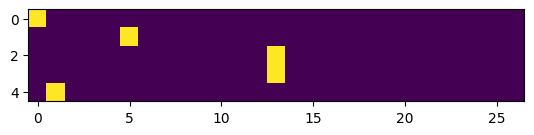

In [45]:
plt.imshow(xencoded)

### The $0th$ example corresponded to feeding in a ```'.'``` to the neural network. We did this by:
- first getting its index:
  ```python
  xs.append(ix1)
  ```
- one-hot encoding it:
  ```python
  xencoded = F.one_hot(xs, num_classes=27).float()
  ```

- put it through the neural net (The one-hot encoded input vector for the 0th example is multiplied with the weight matrix W):
  ```python
  xencoded @ W
  ```
- and outputted ```probs[0]``` distribution of probabilities, with a shape of $27$ numbers. We interpret these as the nn's assignment for how likely every one of the $27$ characters are likely to come next.

### As we tune the weights W, we will get different probabilities out, for every character that we input. Now, the question is if we can optimize and finally get W such that the probabilities are pretty good that are outputted. We judge this by the loss function.

### Nice Job! If you don't understand it all right away, that's okay. A good and concise summary with code will be provided at the beginning of the next lesson.